In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
# from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from torchvision.utils import make_grid
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [35]:
# transformation to the image dataseet:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to a fixed size
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()           # Convert images to PyTorch tensors and scale to [0, 1]
])

In [62]:
train_dir = 'C:/Users/tessa/OneDrive/Documents/1. MS BMI/4. Spring 2024/1. Deep Learning 6114/DL_Project/Alzheimer_s Dataset/train/'
ds_train = datasets.ImageFolder(train_dir, transform=transform)
dl_train = DataLoader(ds_train, batch_size=64, shuffle=True)

test_dir = 'C:/Users/tessa/OneDrive/Documents/1. MS BMI/4. Spring 2024/1. Deep Learning 6114/DL_Project/Alzheimer_s Dataset/test/'
ds_test = datasets.ImageFolder(test_dir, transform=transform)
dl_test = DataLoader(ds_test, batch_size=64, shuffle=False)

In [63]:
codings_size = 100
image_size = (128, 128)

In [72]:
g = nn.Sequential(
    nn.ConvTranspose2d(100, 128, 4, 1, 0, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.ConvTranspose2d(128, 64, 3, 2, 1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(),

    nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=False),
    nn.Tanh()
)

summary(g, input_size=(64, codings_size, 1, 1), device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64, 1, 28, 28]           --
├─ConvTranspose2d: 1-1                   [64, 128, 4, 4]           204,800
├─BatchNorm2d: 1-2                       [64, 128, 4, 4]           256
├─ReLU: 1-3                              [64, 128, 4, 4]           --
├─ConvTranspose2d: 1-4                   [64, 64, 7, 7]            73,728
├─BatchNorm2d: 1-5                       [64, 64, 7, 7]            128
├─ReLU: 1-6                              [64, 64, 7, 7]            --
├─ConvTranspose2d: 1-7                   [64, 32, 14, 14]          32,768
├─BatchNorm2d: 1-8                       [64, 32, 14, 14]          64
├─ReLU: 1-9                              [64, 32, 14, 14]          --
├─ConvTranspose2d: 1-10                  [64, 1, 28, 28]           512
├─Tanh: 1-11                             [64, 1, 28, 28]           --
Total params: 312,256
Trainable params: 312,256
Non-trainable params:

In [73]:
d = nn.Sequential(
    nn.Conv2d(1, 32, 4, 2, 1, bias=False),
    nn.LeakyReLU(0.2),

    nn.Conv2d(32, 64, 4, 2, 1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2),

    nn.Conv2d(64, 128, 3, 2, 1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2),

    nn.Conv2d(128, 1, 4, 1, 0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

summary(d, input_size=(64, 1, 28, 28), device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64, 1]                   --
├─Conv2d: 1-1                            [64, 32, 14, 14]          512
├─LeakyReLU: 1-2                         [64, 32, 14, 14]          --
├─Conv2d: 1-3                            [64, 64, 7, 7]            32,768
├─BatchNorm2d: 1-4                       [64, 64, 7, 7]            128
├─LeakyReLU: 1-5                         [64, 64, 7, 7]            --
├─Conv2d: 1-6                            [64, 128, 4, 4]           73,728
├─BatchNorm2d: 1-7                       [64, 128, 4, 4]           256
├─LeakyReLU: 1-8                         [64, 128, 4, 4]           --
├─Conv2d: 1-9                            [64, 1, 1, 1]             2,048
├─Flatten: 1-10                          [64, 1]                   --
├─Sigmoid: 1-11                          [64, 1]                   --
Total params: 109,440
Trainable params: 109,440
Non-trainable params: 0

In [74]:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(g.parameters())
d_optimizer = torch.optim.Adam(d.parameters())

In [75]:
# Training the generator
def g_training_step(d, g, optimizer, x_batch):
    batch_size = x_batch.size(0)
    
    z = torch.randn(batch_size, codings_size, 1, 1)

    pred_fake = d(g(z))
    loss = loss_fn(pred_fake, torch.ones(batch_size, 1)) # Trying to fool the discriminator
                                                         # by passing the fake data as real.

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    return loss.item()
    
# Training the discriminator
def d_training_step(d, g, optimizer, x_batch):
    batch_size = x_batch.size(0)
    
    # Train discriminator on a real batch
    pred_real = d(x_batch)
    loss_real = loss_fn(pred_real, torch.ones(batch_size, 1))

    # Train discriminator on a fake batch
    z = torch.randn(batch_size, codings_size, 1, 1)

    pred_fake = d(g(z))
    loss_fake = loss_fn(pred_fake, torch.zeros(batch_size, 1))

    # Total loss
    loss = loss_real + loss_fake
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
    return loss.item()

In [76]:
def create_samples(g, z):
    g_output = g(z)
    print("Generator output shape:", g_output.shape)
    # images = torch.reshape(g_output, (batch_size, *Size))  
    images = g_output  # No need to reshape if you want to keep the same shape
    return (images + 1) / 2.0

batch_size = 32

z = torch.randn(batch_size, codings_size, 1, 1)

epoch_samples = []

all_d_losses = []
all_g_losses = []

epochs = 20
for epoch in range( epochs):           
    d_losses, g_losses = [], []
    
    for x_batch, _ in dl_train:
        d_losses.append(d_training_step(d, g, d_optimizer, x_batch))
        g_losses.append(g_training_step(d, g, g_optimizer, x_batch))
 
    all_d_losses.append(torch.tensor(d_losses).mean())
    all_g_losses.append(torch.tensor(g_losses).mean())

    print(f"Epoch{epoch + 1: 3d}/{epochs}: g_loss={all_g_losses[-1]:.4f}, d_loss={all_d_losses[-1]:.4f}")
    epoch_samples.append(create_samples(g, z).detach().numpy())

Epoch  1/20: g_loss=6.5808, d_loss=0.0490
Generator output shape: torch.Size([32, 1, 28, 28])
Epoch  2/20: g_loss=7.3593, d_loss=0.0051
Generator output shape: torch.Size([32, 1, 28, 28])
Epoch  3/20: g_loss=8.2341, d_loss=0.0048
Generator output shape: torch.Size([32, 1, 28, 28])
Epoch  4/20: g_loss=8.6959, d_loss=0.0024
Generator output shape: torch.Size([32, 1, 28, 28])
Epoch  5/20: g_loss=7.6329, d_loss=0.1459
Generator output shape: torch.Size([32, 1, 28, 28])
Epoch  6/20: g_loss=7.4293, d_loss=0.0201
Generator output shape: torch.Size([32, 1, 28, 28])
Epoch  7/20: g_loss=7.3671, d_loss=0.0255
Generator output shape: torch.Size([32, 1, 28, 28])
Epoch  8/20: g_loss=7.3195, d_loss=0.0760
Generator output shape: torch.Size([32, 1, 28, 28])
Epoch  9/20: g_loss=6.7388, d_loss=0.0429
Generator output shape: torch.Size([32, 1, 28, 28])
Epoch 10/20: g_loss=8.3826, d_loss=0.1061
Generator output shape: torch.Size([32, 1, 28, 28])
Epoch 11/20: g_loss=7.0209, d_loss=0.0467
Generator output s

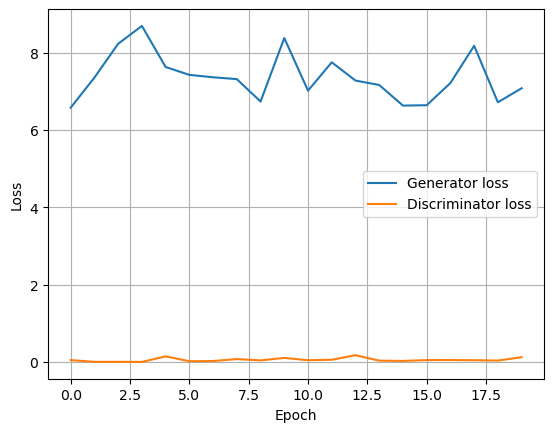

In [77]:
plt.plot(all_g_losses, label='Generator loss')
plt.plot(all_d_losses, label='Discriminator loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

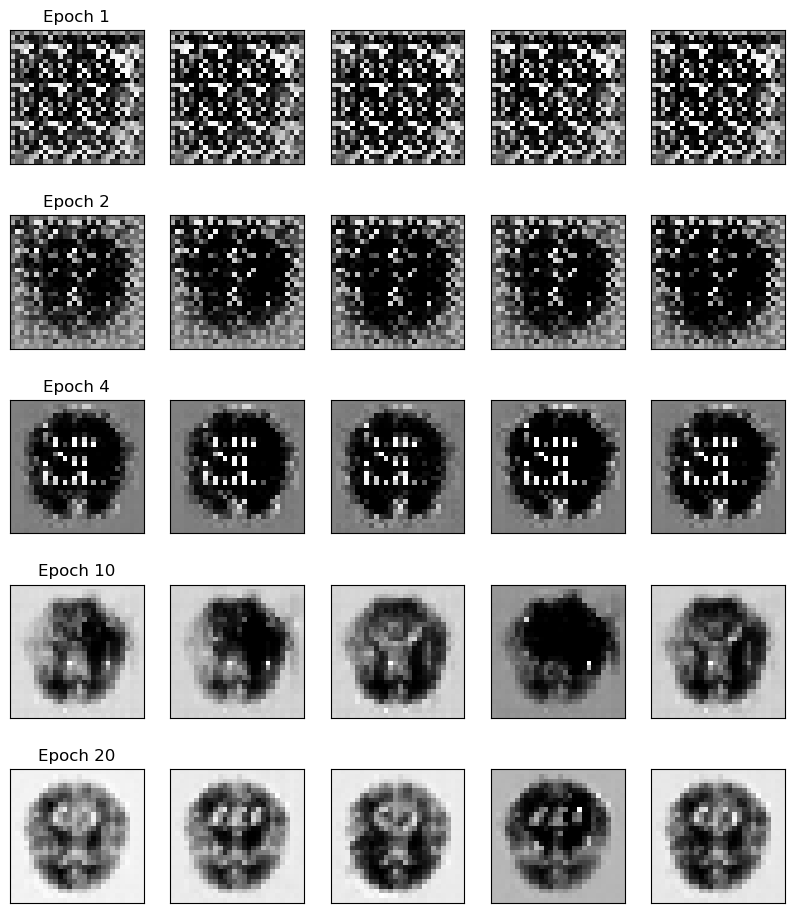

In [78]:
selected_epochs = [1, 2, 4, 10, 20]
fig = plt.figure(figsize=(10, 14))
for i, e in enumerate(selected_epochs):
    for j in range(5):
        plt.subplot(6, 5, i * 5 + j + 1)
        plt.xticks([])
        plt.yticks([])
        if j == 0:
            plt.title(f'Epoch {e}')
        image = np.squeeze(epoch_samples[e - 1][j])  # Squeeze the first dimension
        plt.imshow(image, cmap='binary')
    
plt.show()

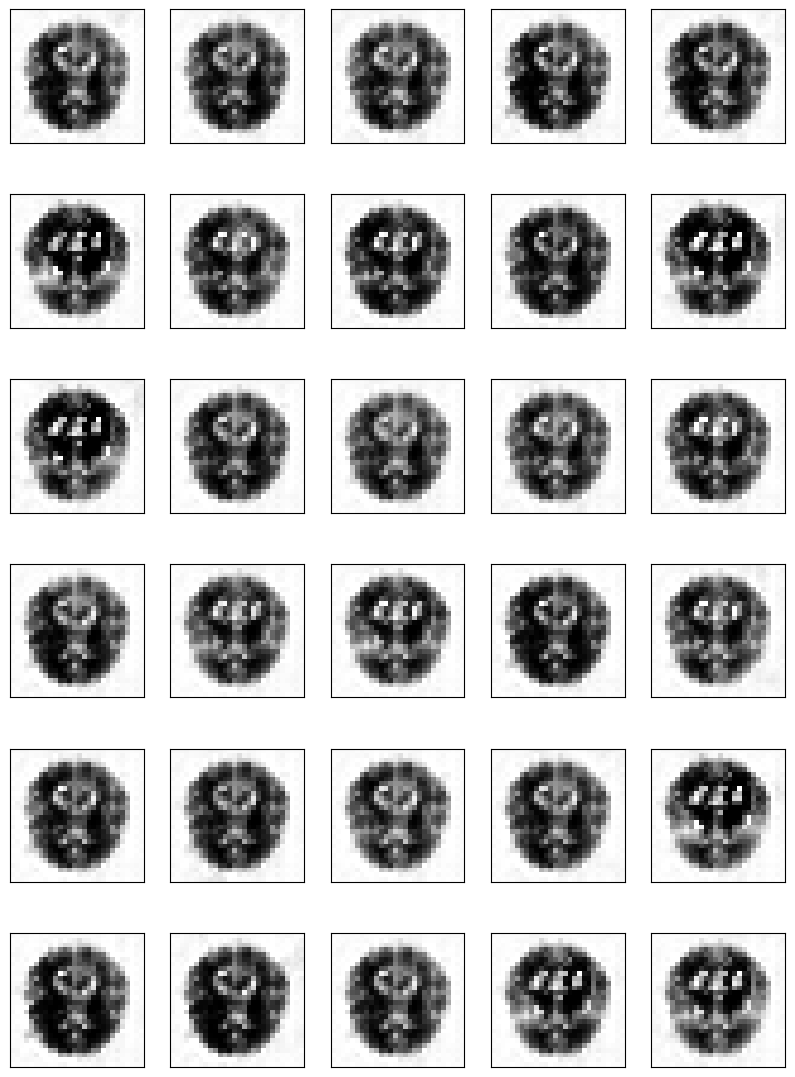

In [79]:
z = torch.randn(batch_size, codings_size, 1, 1)

images = np.clip(g(z).detach().permute(0, 2, 3, 1), 0, 1)
fig = plt.figure(figsize=(10, 14))
for i in range(30):
    plt.subplot(6, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images[i], cmap='binary')